Build feature and output arrays

In [2]:
import numpy as np
import pandas as pd
import json
from sklearn.preprocessing import OneHotEncoder

# Listen für alle Daten
all_turbine_types = []
all_hub_heights = []
all_capacities = []
all_commissioning_dates = []
all_production_data = []

# JSON-Datei laden
with open(f"data/WPPs+production+wind.json", "r", encoding="utf-8") as file:
    WPP_production_wind = json.load(file)

# Daten sammeln
for wpp in WPP_production_wind:
    all_turbine_types.append(wpp["Turbine"])
    all_hub_heights.append(wpp["Hub_height"] if not pd.isna(wpp["Hub_height"]) else 100)
    all_capacities.append(wpp["Capacity"])
    all_commissioning_dates.append(wpp["Commission_date"] if wpp["Commission_date"] != "nan" else "2015/06")
    all_production_data.append(wpp["Production"])

# NaN-Werte in Turbinentypen durch eindeutige Namen ersetzen
nan_counter = 1
for idx, turbine in enumerate(all_turbine_types):
    if pd.isna(turbine):
        all_turbine_types[idx] = f"nan{nan_counter}"
        nan_counter += 1

# One-Hot-Encoding für Turbinentypen
encoder = OneHotEncoder(sparse_output=False)
turbine_types_onehot = encoder.fit_transform(np.array(all_turbine_types).reshape(-1, 1))

# Datumsformat korrigieren
all_commissioning_dates = [
    "2015/06" if date == "nan" else f"{date}/06" if isinstance(date, str) and "/" not in date else date
    for date in all_commissioning_dates
]

# In datetime konvertieren
standardised_dates = pd.to_datetime(all_commissioning_dates, format='%Y/%m')

# Berechnung des Alters
current_date = pd.Timestamp("2024-12-01")
ages = current_date.year * 12 + current_date.month - (standardised_dates.year * 12 + standardised_dates.month)

# Kombinierte Features und Outputs erstellen
combined_features_raw = []
output_raw = []

# Daten in Feature-Arrays konvertieren
for idx, production_data in enumerate(all_production_data):
    num_rows = len(production_data)

    # Wiederholungen für allgemeine Features
    turbine_type_repeated = np.tile(turbine_types_onehot[idx], (num_rows, 1))
    hub_height_repeated = np.full((num_rows, 1), all_hub_heights[idx])
    capacity_repeated = np.full((num_rows, 1), all_capacities[idx])
    age_repeated = np.full((num_rows, 1), ages[idx])

    # Extrahiere Produktionswerte und Windgeschwindigkeiten
    production_values = np.array([entry[1] for entry in production_data]).reshape(-1, 1)
    wind_speeds = np.array([entry[2] for entry in production_data]).reshape(-1, 1)

    # Kombiniere alle Features
    combined_chunk = np.hstack((
        turbine_type_repeated,  # One-Hot Turbinen-Typ
        hub_height_repeated,    # Nabenhöhe
        capacity_repeated,      # Kapazität
        age_repeated,           # Alter
        wind_speeds             # Windgeschwindigkeit
    ))

    # Füge die Daten hinzu
    combined_features_raw.append(combined_chunk)
    output_raw.append(production_values)

# Kombinieren aller Datensätze in einem großen Array
combined_features_raw = np.vstack(combined_features_raw)
output_raw = np.vstack(output_raw)

# Alle Werte auf zwei Nachkommastellen runden
combined_features_raw = np.round(combined_features_raw, decimals=2)
output_raw = np.round(output_raw, decimals=2)

Extract subset of data for hyperparameter search (no random sampling, because of time series data)

In [18]:
import numpy as np

# Anzahl der Stichproben
num_samples = 100000

# Zufälligen Startpunkt wählen, der sicherstellt, dass der Bereich gültig bleibt
start_index = np.random.randint(0, combined_features_raw.shape[0] - num_samples)

# Fortlaufende Datenpunkte auswählen
combined_features_subset = combined_features_raw[start_index:start_index + num_samples].copy()
output_subset = output_raw[start_index:start_index + num_samples].copy()

start_index, combined_features_subset.shape, output_subset.shape

(2731977, (100000, 53), (100000, 1))

Scale feature vector and define Dataset

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torch

combined_features = combined_features_subset.copy()
output = output_subset.copy()

# Standardisierung der numerischen Features
scaler = StandardScaler()
numerical_columns = slice(turbine_types_onehot.shape[1], combined_features.shape[1] )
combined_features[:, numerical_columns] = scaler.fit_transform(combined_features[:, numerical_columns])

# Trainings- und Testaufteilung
train_features, test_features, train_targets, test_targets = train_test_split(
    combined_features, output, test_size=0.25, random_state=1
)

# Dataset-Klasse für PyTorch
class WindPowerDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.targets[index]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Erstellung der PyTorch-Datasets
train_val_dataset = WindPowerDataset(train_features, train_targets)
test_dataset = WindPowerDataset(test_features, test_targets)

# Ausgabe der Formen
print("Train Features Shape:", train_features.shape)
print("Train Targets Shape:", train_targets.shape)
print("Test Features Shape:", test_features.shape)
print("Test Targets Shape:", test_targets.shape)

Train Features Shape: (75000, 53)
Train Targets Shape: (75000, 1)
Test Features Shape: (25000, 53)
Test Targets Shape: (25000, 1)


Define Model

In [41]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)  # No activation in the output layer for regression
        return x

Hyperparameter search: Training, Validation

In [42]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import shutil
import os
import subprocess
from torch.utils.tensorboard import SummaryWriter

# Hyperparameter-Raum definieren
# param_space = {
#     "hidden_size": [32, 64, 128, 256],
#     "batch_size": [16, 32, 64],
#     "lr": [1e-2, 1e-3, 1e-4],
#     "number_epochs": [20, 50, 100],
# }
param_space = {
    "hidden_size": [32],
    "batch_size": [32],
    "lr": [1e-3],
    "number_epochs": [20],
}

# Funktion zur Auswahl eines zufälligen Parametersets
def random_search(param_space, n_trials):
    trials = []
    for _ in range(n_trials):
        trial = {key: random.choice(values) for key, values in param_space.items()}
        trials.append(trial)
    return trials

# Generiere zufällige Parameterkombinationen
n_trials = 1
params = random_search(param_space, n_trials)[0]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# KFold-Objekt
kf = KFold(n_splits=2, shuffle=False)
len_train_val_dataset = len(train_val_dataset)

# Ergebnis-Tracking
best_val_loss = float("inf")
best_params = None
results = []

input_size = train_features.shape[1]

# TensorBoard-Prozess beenden
try:
    subprocess.run(["taskkill", "/IM", "tensorboard.exe", "/F"], check=True)
    print("TensorBoard-Prozess beendet.")
except subprocess.CalledProcessError:
    print("Kein TensorBoard-Prozess gefunden oder konnte nicht beendet werden.")

log_dir = "runs"

# Löschen, wenn der Ordner existiert
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

# TensorBoard neu starten
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

subprocess.Popen(["tensorboard", "--logdir=runs", "--bind_all"])
print("TensorBoard gestartet.")

avg_val_loss = 0.0  # Durchschnittliche Validierungs-Fehler über die Folds

for fold, (train_idx, val_idx) in enumerate(kf.split(range(len_train_val_dataset)), 1):

    print(f"  Fold {fold}/{kf.n_splits}")
    writer = SummaryWriter(f"{log_dir}/fold_{fold}")

    # Modell
    example_input = torch.randn(params["batch_size"], input_size).to(device)
    model = MLP(input_size=input_size, hidden_size=params["hidden_size"], output_size=1).to(device)

    # Visualisierung der Modellarchitektur
    writer.add_graph(model, example_input)

    # Train- und Validierungsdaten erstellen
    train_fold_dataset = Subset(train_val_dataset, train_idx)
    val_fold_dataset = Subset(train_val_dataset, val_idx)

    train_loader = DataLoader(train_fold_dataset, batch_size=params["batch_size"], shuffle=False)
    val_loader = DataLoader(val_fold_dataset, batch_size=params["batch_size"], shuffle=False)

    # Loss und Optimizer
    criterion = nn.HuberLoss()
    optimizer = optim.Adam(model.parameters(), lr=params["lr"])

    # Training
    for epoch in range(params["number_epochs"]):
        print(f"    Epoch {epoch+1}/{params['number_epochs']}")
        model.train()
        training_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            training_loss += loss.item()

            optimizer.zero_grad()  # Gradienten zurücksetzen
            loss.backward()        # Gradienten berechnen
            optimizer.step()       # Parameter aktualisieren

        # Trainingsverlust protokollieren
        writer.add_scalar("Training Loss", training_loss / len(train_loader), epoch)

    # Validierung
    model.eval()
    fold_val_loss = 0.0
    batch_x_all = []
    batch_y_all = []
    val_outputs_all = []
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x_all.append(batch_x.detach().cpu().numpy())
            batch_y_all.append(batch_y.detach().cpu().numpy())
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            val_outputs = model(batch_x)
            val_outputs_all.append(val_outputs.detach().cpu().numpy())
            fold_val_loss += criterion(val_outputs, batch_y).item()
    
    batch_x_all = np.concatenate(batch_x_all)
    batch_y_all = np.concatenate(batch_y_all)
    val_outputs_all = np.concatenate(val_outputs_all)

    fold_val_loss /= len(val_loader)
    writer.add_scalar("Validation Loss", fold_val_loss, 1)
    print(f"    Fold Validation Loss: {fold_val_loss:.4f}")
    avg_val_loss += fold_val_loss

    # TensorBoard schließen
    writer.close()

avg_val_loss /= kf.n_splits
print(f"  Trial Average Validation Loss: {avg_val_loss:.4f}")

# Ergebnisse speichern
results.append({"params": params, "avg_val_loss": avg_val_loss})

# Bestes Ergebnis aktualisieren
if avg_val_loss < best_val_loss:
    best_val_loss = avg_val_loss
    best_params = params

print(f"\nBest Parameters: {best_params}")
print(f"Best Validation Loss: {best_val_loss:.4f}")

TensorBoard-Prozess beendet.
TensorBoard gestartet.
  Fold 1/2
    Epoch 1/20
    Epoch 2/20
    Epoch 3/20
    Epoch 4/20
    Epoch 5/20
    Epoch 6/20
    Epoch 7/20
    Epoch 8/20
    Epoch 9/20
    Epoch 10/20
    Epoch 11/20
    Epoch 12/20
    Epoch 13/20
    Epoch 14/20
    Epoch 15/20
    Epoch 16/20
    Epoch 17/20
    Epoch 18/20
    Epoch 19/20
    Epoch 20/20
    Fold Validation Loss: 10.6138
  Fold 2/2
    Epoch 1/20


KeyboardInterrupt: 

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Feature-Namen definieren
feature_names = np.array((
    list(encoder.get_feature_names_out(["Turbine"])) + 
    ["Hub_height", "Capacity", "Age", "Wind_speed"]
))

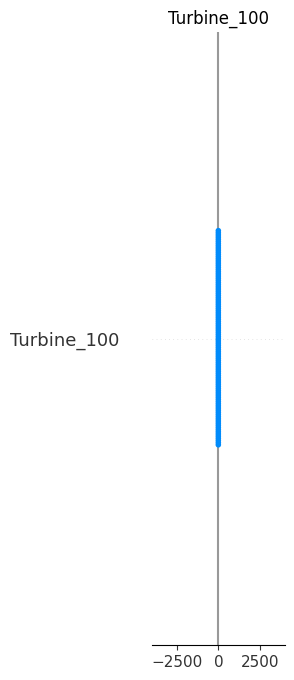

In [15]:
import shap

# Eingabegröße korrigieren
input_tensor = torch.tensor(combined_features_subset[:100], dtype=torch.float32).to(device)

# SHAP-Explainer erstellen
explainer = shap.GradientExplainer(model, input_tensor)

# SHAP-Werte berechnen
shap_values = explainer.shap_values(input_tensor)

# Visualisierung
shap.summary_plot(
    shap_values, combined_features_subset[:100], feature_names=feature_names
)


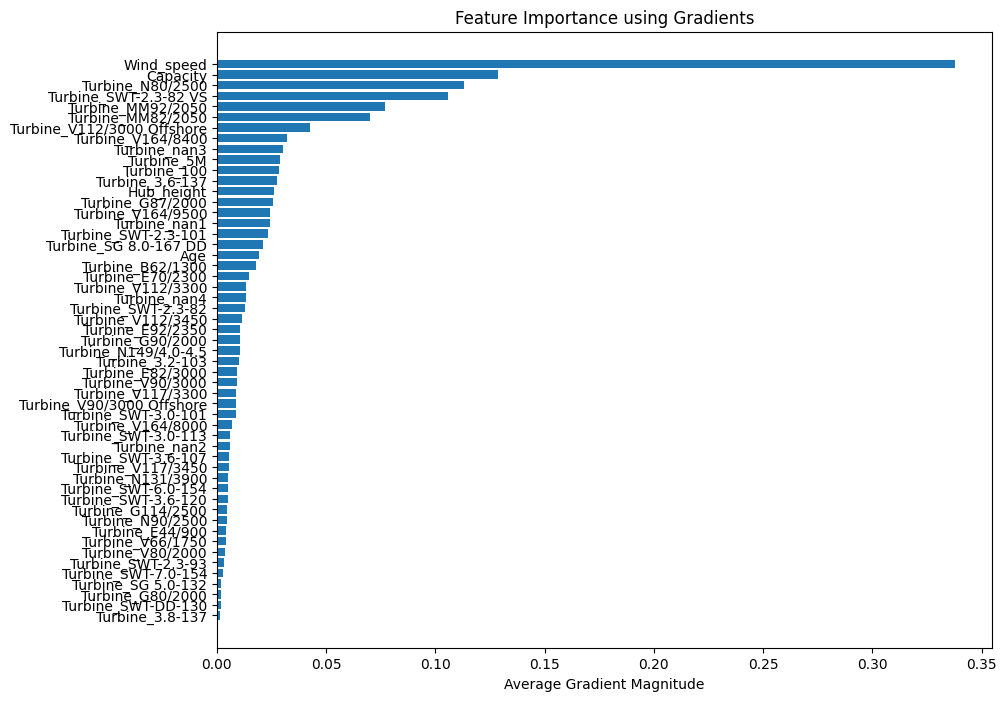

In [50]:
# Modell in Evaluierungsmodus
model.eval()

# Eingabegröße reduzieren
inputs = torch.tensor(combined_features[:100], dtype=torch.float32, requires_grad=True).to(device)

# Vorhersage berechnen
outputs = model(inputs)

# Mittleren Output für den Gradienten berechnen
outputs.mean().backward()

# Gradienten extrahieren und sortieren
feature_importance = inputs.grad.abs().mean(dim=0).cpu().detach().numpy()

# Nach Wichtigkeit sortieren
sorted_idx = np.argsort(feature_importance)

# Visualisierung
plt.figure(figsize=(10, 8))
plt.barh(np.array(feature_names)[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Average Gradient Magnitude")
plt.title("Feature Importance using Gradients")
plt.show()


<h1>Visualisation of validation results

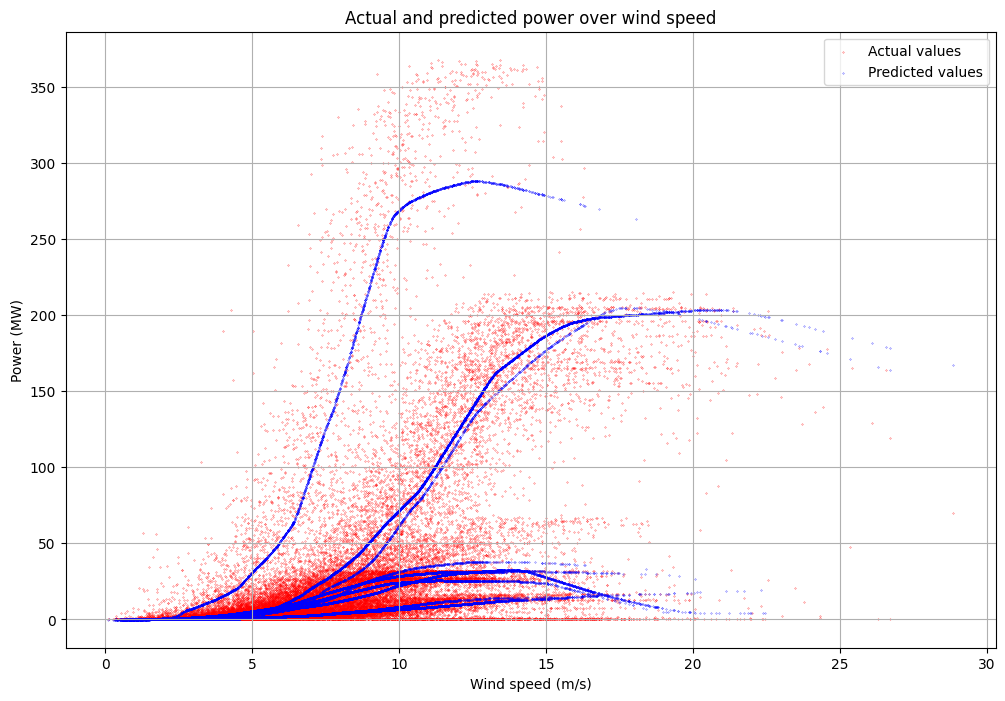

C:\Users\alexa\AppData\Local\Temp\ipykernel_11324\662932076.py:14: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(batch_x_all, (val_outputs_all-batch_y_all) / batch_y_all, color='blue', s=0.05)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11324\662932076.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


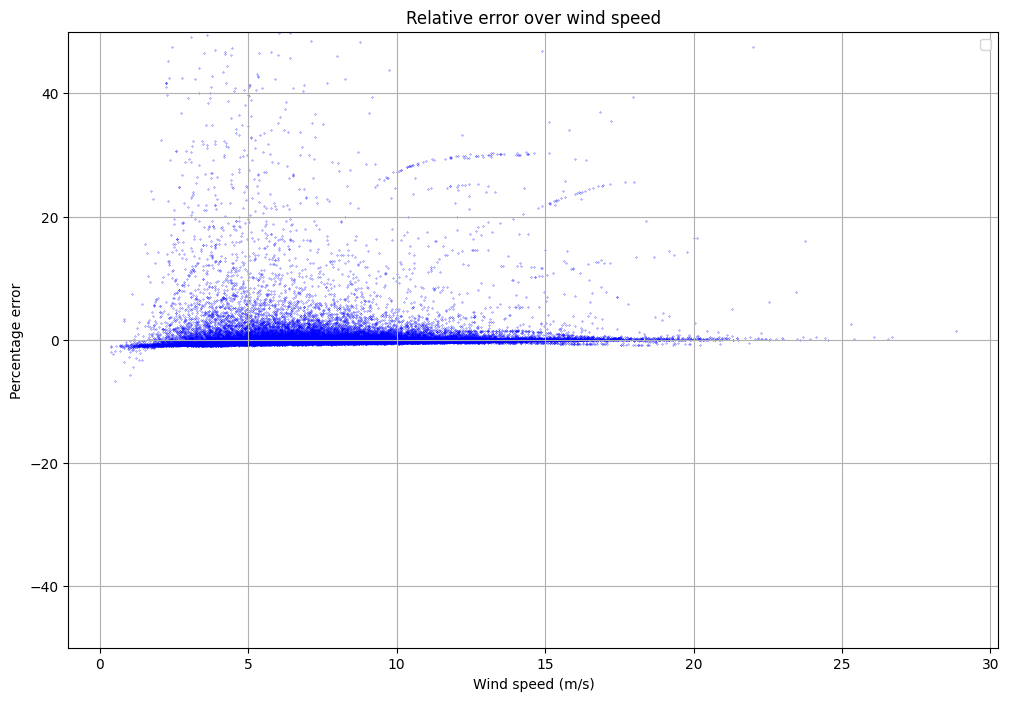

C:\Users\alexa\AppData\Local\Temp\ipykernel_11324\662932076.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


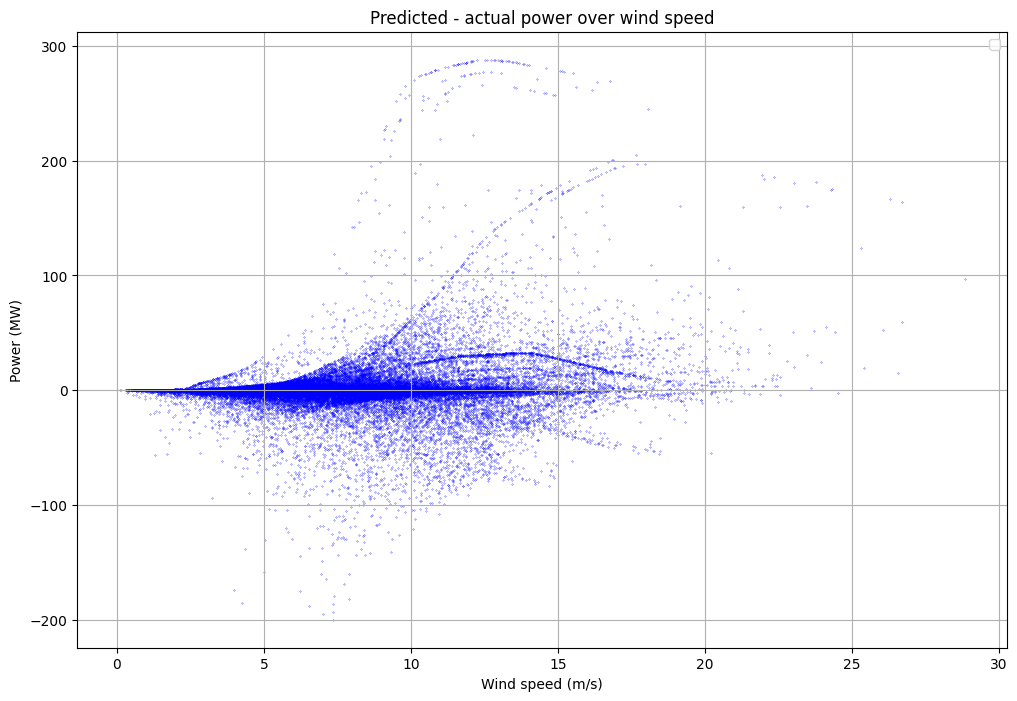

last ten validation values:
        wind speed  actual values  predicted values
0            7.89       2.020000          4.229115
1            5.40      25.070000          5.627995
2            9.09      27.959999         25.348606
3            5.28      20.930000          5.542847
4           11.69      11.830000          9.116287
...           ...            ...               ...
37495        7.42      28.260000         16.594019
37496        4.52       0.000000          2.331296
37497        1.61       0.000000         -0.006070
37498       12.25     174.619995        132.212570
37499        0.82       0.000000         -0.072382

[37500 rows x 3 columns]


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.scatter(batch_x_all, batch_y_all, s=0.05, color='red', label="Actual values")
plt.scatter(batch_x_all, val_outputs_all, s=0.05, color='blue', label="Predicted values")
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (MW)')
plt.title('Actual and predicted power over wind speed')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(batch_x_all, (val_outputs_all-batch_y_all) / batch_y_all, color='blue', s=0.05)
plt.ylim(-10, 50)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Percentage error')
plt.title('Relative error over wind speed')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(batch_x_all, val_outputs_all-batch_y_all, color='blue', s=0.05)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (MW)')
plt.title('Predicted - actual power over wind speed')
plt.legend()
plt.grid(True)
plt.show()

# Tabelle erstellen und anzeigen
results_df = pd.DataFrame({
    "wind speed": batch_x_all,
    "actual values": batch_y_all.flatten(),
    "predicted values": val_outputs_all.flatten()
})
print("last ten validation values:\n", results_df)

With best hyperparameters: Training and Testing

In [ ]:

# Test mit besten Parametern
example_input = torch.randn(best_params["batch_size"], input_size).to(device)
model = torch.jit.trace(
    MLP(input_size=input_size, hidden_size=best_params["hidden_size"], output_size=1).to(device), example_input
)
criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])

train_loader = DataLoader(train_val_dataset, batch_size=best_params["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Training mit besten Parametern
for epoch in range(best_params["number_epochs"]):
    model.train()
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Test mit Testdaten
model.eval()
test_loss = 0.0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        test_outputs = model(batch_x)
        test_loss += criterion(test_outputs, batch_y).item()

test_loss /= len(test_loader)
print(f"\nTest Loss: {test_loss:.4f}")

# Modell speichern
torch.save(model.state_dict(), "mlp_wind_power_model_best.pth")

Calculate Spearman Correlation Coefficient for a first idea of important features

In [66]:
import pandas as pd

num_turbine_type_columns = turbine_types_onehot.shape[1]

# DataFrame ohne Turbinentypen erstellen
df = pd.DataFrame(
    combined_features[:, num_turbine_type_columns:], 
    columns=["Hub Height", "Capacity", "Commissioning Date", "Wind Speed"]
)

# Ausgabe hinzufügen
df['Power'] = output.flatten()

# Spearman-Korrelation berechnen
spearman_corr_matrix = df.corr(method='spearman')


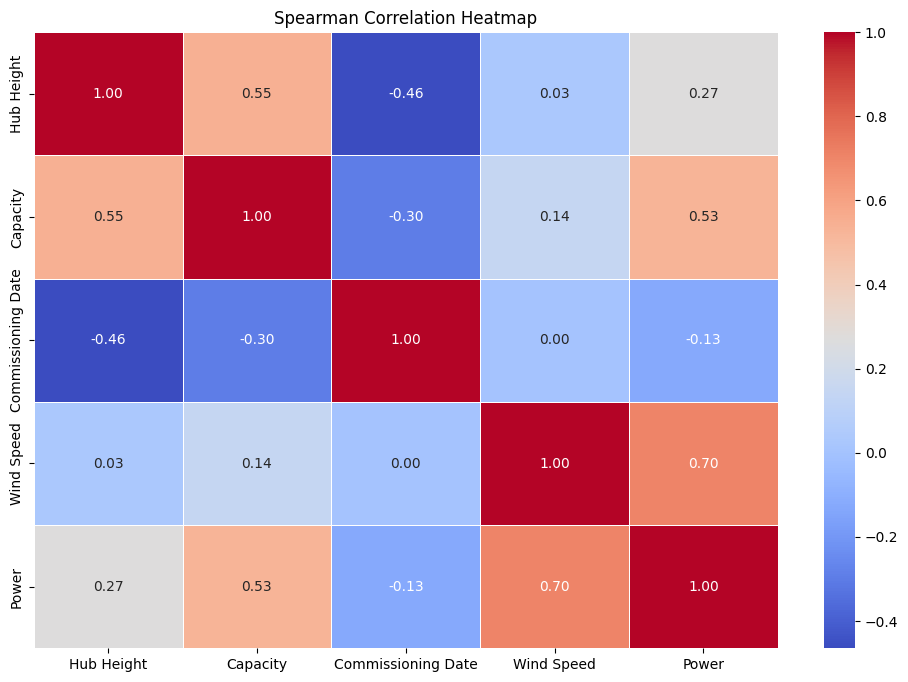

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Farbcodierte Tabelle anzeigen
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Spearman Correlation Heatmap")
plt.show()